In [1]:
# https://walkwithfastai.com/tab.clas.binary
from fastai.tabular.all import *

DS = '/home/javier/mis_proyectos/calculos_Fer/DATAJAVI_V5_deuce.csv'
DS = '/home/javier/mis_proyectos/calculos_Fer/DATAJAVI_V5_ad.csv'

### FASTAI:
df = pd.read_csv(DS)

In [2]:
# import pandas as pd
#   
# # Import the excel file and call it xls_file
# excel_file = pd.ExcelFile(DS)
#   
# # View the excel_file's sheet names
# print(excel_file.sheet_names)
#   
# # # Load the excel_file's Sheet1 as a dataframe
# # df = excel_file.parse('Sheet1')
# # print(df)

In [34]:
print("clases: ", pd.unique(df.Efectividad))

clases:  [3 2 4 1]


In [31]:
df1 = df[df.Efectividad==1].copy() # ace
df2 = df[df.Efectividad==2].copy() # 2 golpes, falla el restador
df3 = df[df.Efectividad==3].copy() # 3 el sacador gana con 4 golpes o menos
df4 = df[df.Efectividad==4].copy() # lo gana el sacador, pero más de 4 golpes. No tiene influencia --> todos los que no son 1, 2 o 3
### los 3 primeros son efectivos --> el saque tiene influencia importante.

In [32]:
df_1_4 = pd.concat([df1,df4])  # dataset with 1 and 4s
df_2_3 = pd.concat([df2,df3])  # dataset with 2 & 3s
df_2_4 = pd.concat([df2,df4])  # dataset with 2 & 4s
df2.Efectividad = 1
df3.Efectividad = 1

df_all = pd.concat([df1, df2, df3, df4])  # all together

In [6]:
# ***APScoreBinary:*** Average Precision for single-label binary classification problems  
# ***APScoreMulti:***  Average Precision for multi-label classification problems

In [36]:
cat_names = ['DIRECCIÓN:1 abierto;2 al cuerpo;3 a la T']
cont_names = ['V(km/h)', '[YA]', 'ZA', 'Znet', 'TIME', 'difV', '&(grados)', 'ANG. IN', 'dLinea']
y_names = ['Efectividad']


def train(df, lr, final_epochs, metric, patience, cat_names, cont_names, y_names):
    """metric: metric to monitor at last training"""
    cat = Categorify()
    to = TabularPandas(df, cat, cat_names)
    cats = to.procs.categorify
    norm = Normalize()
    
    splits = RandomSplitter(valid_pct=0.3)(range_of(df))
    procs = [Categorify, FillMissing, Normalize]
    
    procs = [Categorify, FillMissing, Normalize]
    y_names = 'Efectividad'
    y_block = CategoryBlock()
    to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names,
                       y_names=y_names, y_block=y_block, splits=splits)
    
    dls = to.dataloaders(bs=1024)
    # learn = tabular_learner(dls, [256, 128, 128, 64], loss_func=FocalLossFlat(), metrics=[accuracy]) # loss_func=CrossEntropyLossFlat(),  256, 128, 128, 64
    # learn = tabular_learner(dls, [200,100], metrics=[accuracy, BalancedAccuracy(), Recall(), Precision(), APScoreMulti()]) # loss_func=CrossEntropyLossFlat(),  256, 128, 128, 64
    learn = tabular_learner(dls, [200,100], metrics=[accuracy, BalancedAccuracy()]) # loss_func=CrossEntropyLossFlat(),  256, 128, 128, 64

    print("\nLearning Rate: ", lr)
    
    ###
    # lr = 9e-3
    learn.fit_one_cycle(1, slice(lr/(2.6**4),lr))#, moms=(0.8,0.7))
    learn.freeze_to(-2)
    learn.fit_one_cycle(3, slice(lr/(2.6**4),lr))
    learn.unfreeze()
    lr = lr*5 # 4e-2
    learn.fit_one_cycle(3, slice(lr/(2.6**4),lr))
    
    keep_path = learn.path
    learn.path = Path('/home/javier/mis_proyectos/')
    
    # set the model path to a writeable directory. If you don't do this, the code will produce an error on Gradient
    # learn.path = Path(model_path)
    learn.fit_one_cycle(5, slice(1e-4, 8e-3), 
                        cbs=[EarlyStoppingCallback(monitor='balanced_accuracy_score', min_delta=0.0001, patience=3),
                        SaveModelCallback(monitor='balanced_accuracy_score', min_delta=0.01)])
    
    learn.fit_one_cycle(final_epochs, slice(8e-4, 8e-3),
                        cbs=[EarlyStoppingCallback(monitor=metric, min_delta=0.001, patience=patience),
                        SaveModelCallback(monitor=metric, min_delta=0.01)])
    # learn.fit_one_cycle(12, slice(5e-4, 5e-3))
    
    ### reset the model path
    learn.path = keep_path
    
    interp = ClassificationInterpretation.from_learner(learn)
    interp.plot_confusion_matrix()
    interp.print_classification_report()
    return learn, interp

# Experimentos de entrenamiento:
Juntando los 4 subsets el modelo entrena regular, así que vamos a probar lo siguiente:  


1. entrenamiento de los 4 subsets juntos


Learning Rate:  0.0005


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,1.536229,1.384723,0.240583,0.246381,00:00


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,1.455260,1.390522,0.238574,0.266548,00:00
1,1.411402,1.381001,0.266198,0.329587,00:00
2,1.381526,1.373416,0.277248,0.355622,00:00


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,1.313748,1.334904,0.296333,0.378571,00:00
1,1.291351,1.296650,0.355600,0.396473,00:00
2,1.273258,1.284734,0.383727,0.428642,00:00


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,1.228914,1.254654,0.405826,0.430848,00:00
1,1.218185,1.228471,0.424912,0.409090,00:00
2,1.197373,1.220119,0.446509,0.408764,00:00
3,1.178741,1.200073,0.442993,0.408681,00:00


Better model found at epoch 0 with balanced_accuracy_score value: 0.4308479088336449.
No improvement since epoch 0: early stopping


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,1.207922,1.251002,0.411853,0.433010,00:00
1,1.206505,1.243880,0.415871,0.426863,00:00
2,1.200492,1.240434,0.426921,0.418936,00:00
3,1.195135,1.234359,0.435460,0.420721,00:00
4,1.188378,1.229789,0.431944,0.426680,00:00
5,1.180778,1.212008,0.432446,0.415803,00:00
6,1.172797,1.210377,0.439980,0.401976,00:00
7,1.163721,1.219409,0.448016,0.416127,00:00
8,1.154857,1.246766,0.435460,0.393345,00:00
9,1.146213,1.250073,0.431441,0.402070,00:00


Better model found at epoch 0 with accuracy value: 0.4118533432483673.
Better model found at epoch 2 with accuracy value: 0.42692115902900696.
Better model found at epoch 6 with accuracy value: 0.4399799108505249.
No improvement since epoch 7: early stopping


              precision    recall  f1-score   support

           1       0.55      0.57      0.56       207
           2       0.31      0.21      0.25       531
           3       0.27      0.06      0.10       450
           4       0.47      0.77      0.58       803

    accuracy                           0.44      1991
   macro avg       0.40      0.40      0.37      1991
weighted avg       0.39      0.44      0.38      1991



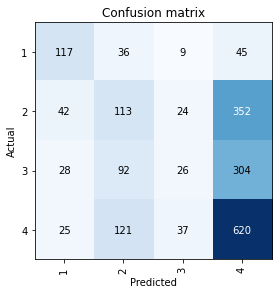

In [9]:
lr, final_epochs, metric, patience = 0.0005, 50, 'accuracy', 3
learn, interp = train(df, lr, final_epochs, metric, patience, cat_names, cont_names, y_names)

2. Entrenamiento de los 4 datasets juntos, obligando a entrenar con más épocas (datasets más complejos suelen necesitar entrenamientos más largos)


Learning Rate:  0.0005


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,1.453404,1.389549,0.231040,0.264949,00:00


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,1.397288,1.392492,0.234053,0.309980,00:00
1,1.372260,1.386979,0.244098,0.350130,00:00
2,1.355800,1.381404,0.255148,0.357850,00:00


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,1.312118,1.351930,0.331994,0.407531,00:00
1,1.298806,1.302457,0.387243,0.419666,00:00
2,1.279902,1.285784,0.392767,0.422532,00:00


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,1.243506,1.272466,0.417880,0.427644,00:00
1,1.229095,1.215662,0.446509,0.427621,00:00
2,1.211605,1.208257,0.453039,0.427447,00:00
3,1.194286,1.201297,0.441487,0.414030,00:00


Better model found at epoch 0 with balanced_accuracy_score value: 0.42764378548666626.
No improvement since epoch 0: early stopping


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,1.219226,1.267419,0.421396,0.432145,00:00
1,1.214914,1.255838,0.429935,0.435914,00:00
2,1.211252,1.247566,0.433451,0.434981,00:00
3,1.208290,1.244959,0.427423,0.430316,00:00
4,1.205520,1.241531,0.430939,0.436984,00:00
5,1.203902,1.238338,0.434455,0.440183,00:00
6,1.200393,1.234849,0.438975,0.438404,00:00
7,1.196772,1.235111,0.439478,0.437622,00:00
8,1.192198,1.229376,0.445003,0.436496,00:00
9,1.187944,1.220415,0.446509,0.431519,00:00


Better model found at epoch 0 with train_loss value: 1.219225525856018.
Better model found at epoch 3 with train_loss value: 1.2082903385162354.
Better model found at epoch 7 with train_loss value: 1.1967717409133911.
Better model found at epoch 10 with train_loss value: 1.1835113763809204.
Better model found at epoch 12 with train_loss value: 1.1730449199676514.
Better model found at epoch 14 with train_loss value: 1.160251259803772.
Better model found at epoch 16 with train_loss value: 1.1474807262420654.
Better model found at epoch 18 with train_loss value: 1.1334917545318604.
Better model found at epoch 20 with train_loss value: 1.1186360120773315.
Better model found at epoch 22 with train_loss value: 1.1063984632492065.
Better model found at epoch 24 with train_loss value: 1.0952008962631226.
Better model found at epoch 26 with train_loss value: 1.0842446088790894.
Better model found at epoch 28 with train_loss value: 1.0736249685287476.
Better model found at epoch 31 with train_l

              precision    recall  f1-score   support

           1       0.53      0.46      0.49       224
           2       0.26      0.25      0.26       551
           3       0.23      0.20      0.21       425
           4       0.44      0.50      0.47       791

    accuracy                           0.36      1991
   macro avg       0.37      0.35      0.36      1991
weighted avg       0.36      0.36      0.36      1991



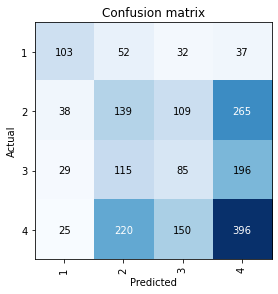

In [10]:
lr, final_epochs, metric, patience = 0.0005, 200, 'train_loss', 100
learn, interp = train(df, lr, final_epochs, metric, patience, cat_names, cont_names, y_names)

3. entrenamiento clasificación binaria --> clases 2 y 3 (las que daban peor)


Learning Rate:  0.0005


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.723203,0.686190,0.566077,0.500840,00:00


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.710857,0.687240,0.571280,0.511874,00:00
1,0.705696,0.688250,0.560874,0.511080,00:00
2,0.699061,0.689548,0.542144,0.503494,00:00


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.686467,0.688591,0.552549,0.535079,00:00
1,0.693861,0.692360,0.534860,0.507697,00:00
2,0.688632,0.689790,0.526535,0.497825,00:00


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.666857,0.687332,0.557752,0.536035,00:00
1,0.675672,0.683949,0.569199,0.526551,00:00
2,0.671736,0.687574,0.550468,0.505528,00:00
3,0.666450,0.701265,0.525494,0.487388,00:00


Better model found at epoch 0 with balanced_accuracy_score value: 0.5360351424742559.
No improvement since epoch 0: early stopping


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.672004,0.688583,0.549428,0.527842,00:00
1,0.667694,0.689827,0.544225,0.521847,00:00
2,0.664022,0.691757,0.529657,0.503661,00:00
3,0.660650,0.695103,0.523413,0.494507,00:00


Better model found at epoch 0 with accuracy value: 0.5494276881217957.
No improvement since epoch 0: early stopping


              precision    recall  f1-score   support

           2       0.59      0.69      0.63       544
           3       0.47      0.36      0.41       417

    accuracy                           0.55       961
   macro avg       0.53      0.53      0.52       961
weighted avg       0.54      0.55      0.54       961



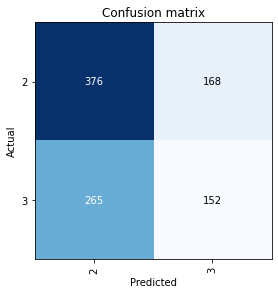

In [12]:
lr, final_epochs, metric, patience = 0.0005, 200, 'accuracy', 3
learn, interp = train(df_2_3, lr, final_epochs, metric, patience, cat_names, cont_names, y_names)

4. Entrenamiento de clasificación binaria de los subsets 1 y 4 (Los que daban mejor)


Learning Rate:  0.0005


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.745349,0.686102,0.617476,0.457259,00:00


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.686180,0.671406,0.691262,0.508705,00:00
1,0.650893,0.644426,0.769903,0.653597,00:00
2,0.620865,0.626646,0.806796,0.761103,00:00


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.563475,0.601794,0.805825,0.793215,00:00
1,0.520921,0.551177,0.844660,0.851890,00:00
2,0.492088,0.522427,0.852427,0.858622,00:00


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.424918,0.483905,0.841748,0.859709,00:00
1,0.419423,0.387611,0.883495,0.860534,00:00
2,0.403052,0.344568,0.890291,0.855120,00:00
3,0.385587,0.326552,0.893204,0.858847,00:00
4,0.372194,0.323424,0.899029,0.860528,00:00


Better model found at epoch 0 with balanced_accuracy_score value: 0.8597088675213675.
No improvement since epoch 1: early stopping


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.418567,0.462428,0.852427,0.862471,00:00
1,0.416264,0.441078,0.858252,0.862228,00:00
2,0.412534,0.423124,0.869903,0.873288,00:00
3,0.409567,0.408140,0.872816,0.865470,00:00
4,0.410438,0.397771,0.876699,0.865949,00:00
5,0.404409,0.387802,0.876699,0.862101,00:00
6,0.399332,0.376601,0.883495,0.862459,00:00
7,0.396794,0.366620,0.885437,0.865585,00:00
8,0.392390,0.359540,0.887379,0.862938,00:00
9,0.388416,0.358303,0.877670,0.847307,00:00


Better model found at epoch 0 with accuracy value: 0.8524271845817566.
Better model found at epoch 2 with accuracy value: 0.8699029088020325.
Better model found at epoch 6 with accuracy value: 0.8834951519966125.
Better model found at epoch 12 with accuracy value: 0.8990291357040405.
No improvement since epoch 22: early stopping


              precision    recall  f1-score   support

           1       0.71      0.79      0.75       198
           4       0.95      0.92      0.94       832

    accuracy                           0.90      1030
   macro avg       0.83      0.86      0.84      1030
weighted avg       0.90      0.90      0.90      1030



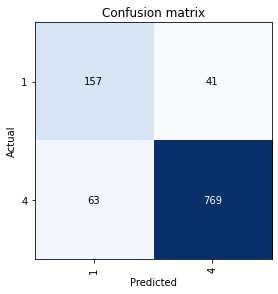

In [13]:
lr, final_epochs, metric, patience = 0.0005, 200, 'accuracy', 20
learn, interp = train(df_1_4, lr, final_epochs, metric, patience, cat_names, cont_names, y_names)

5. Entrenamiento de clasificación binaria juntando clases Efectivas (1,2 y 3) y las no efectivas (4)


Learning Rate:  0.0005


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.730863,0.693238,0.497740,0.547582,00:00


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.698081,0.687343,0.550477,0.579041,00:00
1,0.685080,0.678765,0.570065,0.576844,00:00
2,0.677151,0.673453,0.576595,0.579918,00:00


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.670294,0.674229,0.559016,0.557154,00:00
1,0.662862,0.653901,0.602712,0.592857,00:00
2,0.655771,0.657515,0.589653,0.580758,00:00


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.635737,0.658950,0.568559,0.579240,00:00
1,0.642034,0.655882,0.616776,0.595692,00:00
2,0.644445,0.686644,0.564038,0.559890,00:00
3,0.638695,0.650988,0.606228,0.576919,00:00
4,0.634743,0.650071,0.598192,0.568682,00:00


Better model found at epoch 0 with balanced_accuracy_score value: 0.579239584626205.
Better model found at epoch 1 with balanced_accuracy_score value: 0.5956916346034504.
No improvement since epoch 1: early stopping


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.635246,0.647447,0.608237,0.586859,00:00
1,0.629027,0.645616,0.598192,0.579940,00:00
2,0.622275,0.655974,0.572074,0.558638,00:00
3,0.619834,0.670501,0.565043,0.554969,00:00
4,0.619114,0.674481,0.560020,0.551751,00:00
5,0.618448,0.662695,0.571572,0.564154,00:00


Better model found at epoch 0 with accuracy value: 0.608237087726593.
No improvement since epoch 0: early stopping


              precision    recall  f1-score   support

           1       0.64      0.72      0.68      1151
           4       0.54      0.45      0.49       840

    accuracy                           0.61      1991
   macro avg       0.59      0.59      0.59      1991
weighted avg       0.60      0.61      0.60      1991



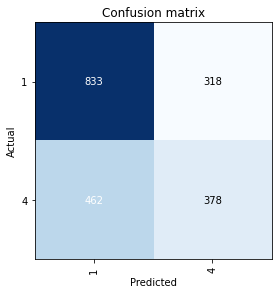

In [44]:
lr, final_epochs, metric, patience = 0.0005, 200, 'accuracy', 5
learn, interp = train(df_all, lr, final_epochs, metric, patience, cat_names, cont_names, y_names)

In [112]:
# learn.validate()

## Conclusiones:
1. Después de entrenar diferentes modelos para deuce y ad, vemos que entrenando los 4 modelos el resultado no es muy bueno. Sin embargo entrenando de 2
en dos sale mucho mejor.  

    1.1. A parte veo que los datos no representan todas las opciones posibles, puesto que no están los que tenían efectividad 0 en el dataset BKG_Corregido. Únicamente se ha tenido en cuenta cuando gana el sacador. Faltarían datos de cuando gana el restador.  

    1.2. Pensar mejor cómo proceder y si es necesario tener todos los datos para el entrenamiento.

2. Ver qué opciones da FastAI para interpretar el modelo xAI

## Pruebas:
1. Entrenar con 1,2,3 vs 4.
2. Entrenar 2 vs 3,4
3. 1vs4,  2vs4, 3vs4  (4 vs all)
4. 1vs all --> igual que el pto 3  -->  1vs2, 1vs3, 1vs4